In [65]:
import os
import math

import pandas
import numpy
import librosa

#import librosa.display
import matplotlib
from matplotlib import pyplot as plt
import seaborn


In [ ]:

time_resolution = 0.020


In [46]:

def load_spectrogram(path, sr=16000, mels=32, time_resolution=0.020):
    y, sr = librosa.load(path, sr=sr)

    hop_length = int(time_resolution * sr)
    n_fft = hop_length * 2
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=mels, hop_length=hop_length, n_fft=n_fft)

    S_db = librosa.power_to_db(S)
    return S_db

def load_files(path):

    out = []
    for name in os.listdir(path):
        p = os.path.join(path, name)
        S = load_spectrogram(p, time_resolution=time_resolution)
        
        d = {
            'file': name,
            'spectrogram': S,
        }
        out.append(d)
    df = pandas.DataFrame.from_records(out)
    return df

files = load_files('./data/reference')
files


,file,spectrogram
0,152763__juskiddink__ball-bouncing.wav,"[[-77.05617, -77.05617, -77.05617, -77.05617, ..."
1,264127__impulse94__large-ball-bounce.wav,"[[-25.710285, -36.241535, -33.735413, -30.1439..."
2,365344__angie81dee__snooker-ball-bouncing-on-t...,"[[-65.00445, -60.459656, -62.499863, -60.58793..."
3,656323__miaopolus__tennis-ball-bounce-high-dro...,"[[-45.51292, -49.842026, -57.74961, -54.017635..."
4,366597__jittels__golf-ball-bounce.wav,"[[-83.072624, -83.072624, -79.90302, -58.07937..."


In [96]:

def compute_soundlevel(S, time_resolution):

    e = librosa.db_to_power(S)
    e_time = librosa.power_to_db(e.sum(axis=0))
    #e = S.sum(axis=0)
    
    tt = numpy.arange(len(e_time)) * time_resolution
    df = pandas.DataFrame({
        'energy': e_time,
        'time': tt,
    }).set_index('time')
    return df
    

def normalize_energy(e):
    min = numpy.min(e, axis=0)
    #max = numpy.max(e, axis=0)

    n = e - min
    n = n / numpy.max(n, axis=0)
    
    return n


def relative_soundlevel(S, time_resolution):
    sl = compute_soundlevel(S, time_resolution=time_resolution)

    # scale to 0.0-1.0
    n = normalize_energy(sl)
    return n
    

def compute_peakyness(levels):
    
    # bounces have both a high soundlevel, and a rapid change in soundlevel
    p = levels * levels.diff(1).abs()

    peakyness = normalize_energy(p)
    
    return peakyness


def merge_events(times, min_distance=0.01):
    # XXX: assumes that times are sorted, increasing order
    out = []
    previous_t = float('-inf')
    for t in times:
        dt = t - previous_t
        if dt >= min_distance:
            previous_t = t
            out.append(t)

    return numpy.array(out)


def find_bounce_times(peakyness, threshold=0.50):
    p = normalize_energy(peakyness)
    bounces = p[p.energy >= threshold]
    bb = merge_events(bounces.index, min_distance=time_resolution*4.0)

    return bb

    
files['soundlevel'] = files.spectrogram.apply(relative_soundlevel, time_resolution=time_resolution)
files['peakyness'] = files['soundlevel'].apply(compute_peakyness)
files['peak_threshold'] = 0.25
files['bounce_times'] = files.peakyness.apply(find_bounce_times, threshold=0.25)

files

,file,spectrogram,soundlevel,peakyness,peak_threshold,bounce_times
0,152763__juskiddink__ball-bouncing.wav,"[[-77.05617, -77.05617, -77.05617, -77.05617, ...",energy time 0.00 0.00000...,energy time 0.00 Na...,0.25,"[0.24, 1.6, 2.84, 3.96, 4.98, 5.92, 6.8, 7.600..."
1,264127__impulse94__large-ball-bounce.wav,"[[-25.710285, -36.241535, -33.735413, -30.1439...",energy time 0.00 0.192617 0...,energy time 0.00 NaN 0...,0.25,"[0.22, 1.1400000000000001, 1.98, 2.74, 3.46, 4..."
2,365344__angie81dee__snooker-ball-bouncing-on-t...,"[[-65.00445, -60.459656, -62.499863, -60.58793...",energy time 0.00 0.225754 0...,energy time 0.00 NaN 0...,0.25,"[0.38, 0.8, 1.16, 1.52, 1.84, 2.14, 2.44, 2.7,..."
3,656323__miaopolus__tennis-ball-bounce-high-dro...,"[[-45.51292, -49.842026, -57.74961, -54.017635...",energy time 0.00 0.238540 0...,energy time 0.00 NaN 0...,0.25,"[0.42, 1.1400000000000001, 1.68, 2.1, 2.42]"
4,366597__jittels__golf-ball-bounce.wav,"[[-83.072624, -83.072624, -79.90302, -58.07937...",energy time 0.00 0.000000 0...,energy time 0.00 NaN 0...,0.25,"[0.36, 1.04, 1.6, 2.08, 2.5, 2.86, 3.18, 3.44,..."


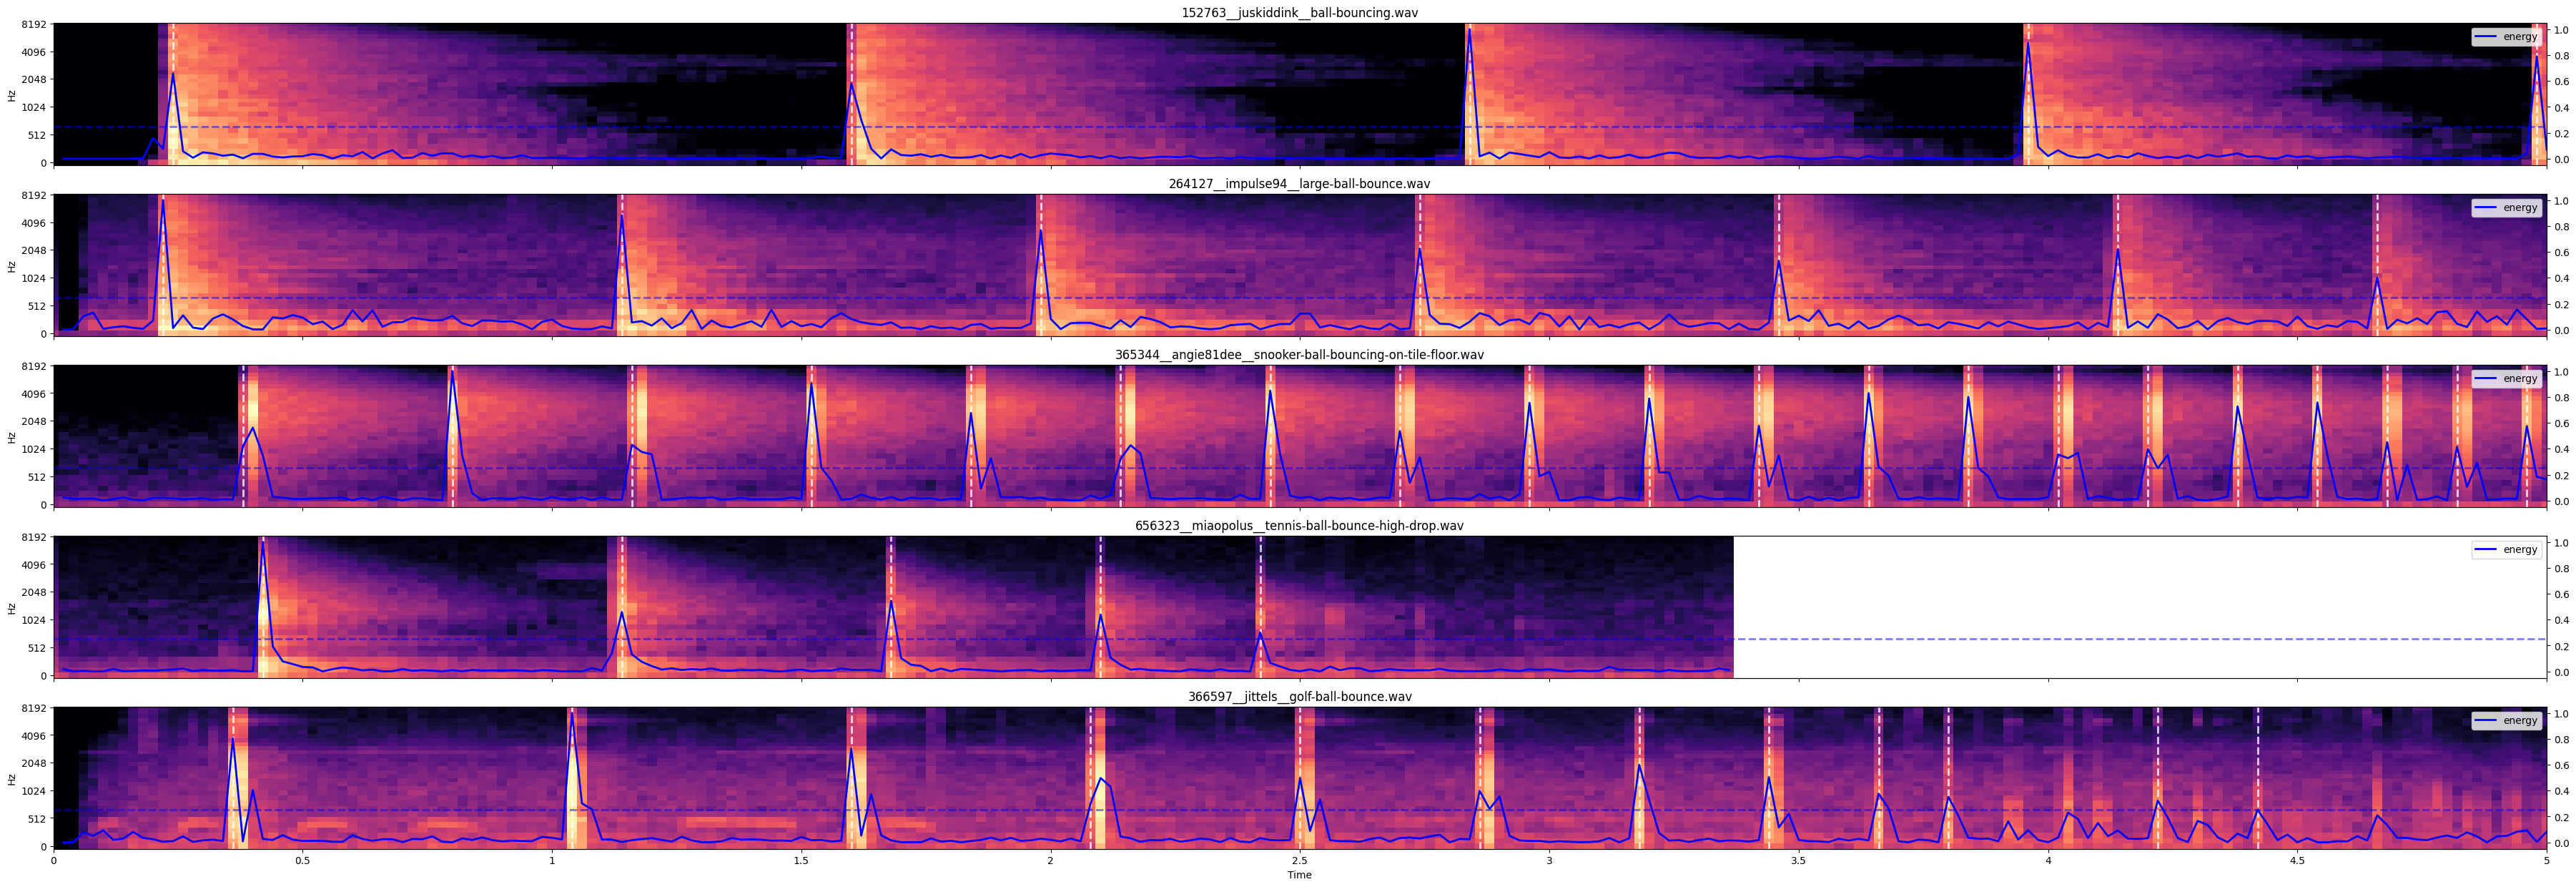

In [97]:

def plot_file(row, ax=None, sr=16000):

    ax.set_title(row['file'])
    hop = int(time_resolution * sr)

    # Spectrogram
    S = row['spectrogram']    
    librosa.display.specshow(ax=ax, data=S,
                             y_axis='mel', x_axis='time',
                             sr=sr, hop_length=hop,
                             cmap='magma')

    # Bounce detection
    ax2 = ax.twinx()

    p = row['peakyness']
    p.plot(ax=ax2, color='blue', lw=2.0)
    
    threshold = row['peak_threshold']
    ax2.axhline(y=threshold, color='blue', lw=2.0, ls='--', alpha=0.5)
    
    bounces = row['bounce_times']
    for t in bounces:
        ax.axvline(x=t, color='white', lw=2.0, ls='--', alpha=0.8)
    


def plot_files(files, height=3.0, aspect=3.0):
    h = len(files) * height
    w = h * aspect
    fig, axs = plt.subplots(len(files), figsize=(w, h), sharex=True, sharey=True)

    for ax, (idx, row) in zip(axs, files.iterrows()):
        plot_file(row, ax=ax)
        ax.set_xlim(0, 5.0)


plot_files(files)




In [98]:
def extract_pairs(values):
    out = []

    for s, e in zip(values, values[1:]):
        out.append((s, e))

    o = numpy.stack(out)
    return o

def extract_bounce_pairs(files):

    out = []
    for idx, row in files.iterrows():

        bounces = row['bounce_times']
        deltas = numpy.diff(bounces)
        pairs = extract_pairs(deltas)
        
        for i, p in enumerate(pairs):
            d = {
                'index': idx,
                'bounce_no': i,
                'dt1': p[0],
                'dt2': p[1],
                # XXX: also capture time ?
            }
            out.append(d)
    
    df = pandas.DataFrame.from_records(out)
    return df

pairs = extract_bounce_pairs(files)
pairs['ratio'] = pairs.dt2 / pairs.dt1
pairs = pairs[pairs.bounce_no < 10]
pairs

,index,bounce_no,dt1,dt2,ratio
0,0,0,1.36,1.24,0.911765
1,0,1,1.24,1.12,0.903226
2,0,2,1.12,1.02,0.910714
3,0,3,1.02,0.94,0.921569
4,0,4,0.94,0.88,0.936170
5,0,5,0.88,0.80,0.909091
6,0,6,0.80,0.74,0.925000
7,0,7,0.74,0.72,0.972973
8,0,8,0.72,0.66,0.916667
9,0,9,0.66,0.64,0.969697


[(0.5, 1.1)]

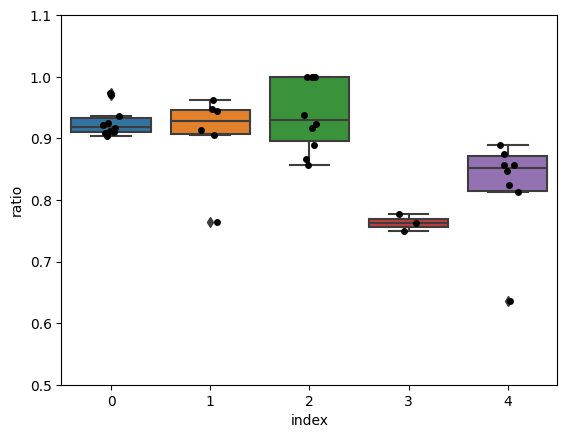

In [103]:

g = seaborn.boxplot(data=pairs, x='index', y='ratio')
g = seaborn.stripplot(data=pairs, x='index', y='ratio', color='black')
g.set(ylim=(0.50, 1.1))
